In [6]:
# from leecarter import leecarter
import pandas as pd
from tqdm import tqdm

import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

from joblib import Memory
location = 'cache'
memory = Memory(location, verbose = 0)


In [7]:
filename = 'death_rates2.txt'

mortality = pd.read_csv(filename, delim_whitespace=True)
mortality = mortality[mortality['Age'] != '110+']
mortality['Age'] = mortality['Age'].astype(int)
mortality['Year'] = mortality['Year'].astype(int)
mortality = mortality[mortality['Age'] <= 100]
mortality['Female_l'] = np.log(mortality['Female'].astype(float))
mortality['Male_l'] = np.log(mortality['Male'].astype(float))
mortality['Total_l'] = np.log(mortality['Total'].astype(float))
mortality = mortality[['Year', 'Age', 'Female_l', 'Male_l', 'Total_l']]
mortality

,Year,Age,Female_l,Male_l,Total_l
0,1958,0,-2.723920,-2.480397,-2.591788
1,1958,1,-5.352562,-5.291540,-5.320972
2,1958,2,-6.357324,-6.197751,-6.272237
3,1958,3,-6.732962,-6.527266,-6.622576
4,1958,4,-7.066751,-6.837297,-6.943382
...,...,...,...,...,...
6867,2019,96,-1.240243,-1.143835,-1.220129
6868,2019,97,-1.123130,-1.046502,-1.108135
6869,2019,98,-1.127061,-0.963167,-1.093425
6870,2019,99,-0.980088,-0.864780,-0.957410


# Lee-Carter model implementation

In [40]:
def fit_arima(matrix):
    d = []
    for a in range(5):
        for b in range(5):
            for c in range(5):
                mod = ARIMA(matrix, order=(a,b,c))
                res = mod.fit()
                d.append([res.llf, a, b, c])

    return max(d)


def predict(matrix, column: str = 'Female_l', age = 65, steps=21):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,0:round(np.shape(fm)[1]*2/3)]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    _, par1, par2, par3 = fit_arima(k_t)
    mod = ARIMA(k_t, order=(par1,par2,par3))
    res = mod.fit()

    pred = res.forecast(steps=steps)
    return np.exp(a_x[age] + b_x[age]*pred)

In [41]:
age = 65
column = 'Female_l'

In [42]:
vals = predict(mortality, column, age)

In [43]:
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))
real_vals

,Year,Age,Female_l
65,1958,65,0.020337
176,1959,65,0.021817
287,1960,65,0.019643
398,1961,65,0.019515
509,1962,65,0.020237
...,...,...,...
6392,2015,65,0.010841
6503,2016,65,0.010374
6614,2017,65,0.010702
6725,2018,65,0.010264


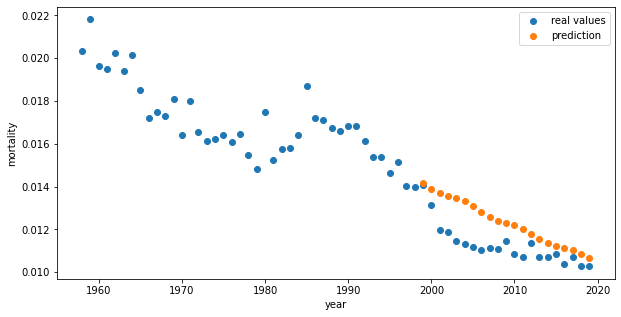

In [44]:
plt.figure(figsize=(10,5))
plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
plt.xlabel('year')
plt.ylabel('mortality')
plt.legend()
plt.savefig('figure.svg')

# Lee-Carter implementation in rolling window scheme

In [82]:
def predict_rolling(fm_train, age):
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)

    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    theta = (k_t[-1] - k_t[0]) / (len(k_t) - 1) #according to the Girosi, King, 2007 and Lee Carter done it the same way. ARIMA was exploding

    pred = k_t[-1] + theta
    return np.exp(a_x[age] + b_x[age]*pred)

def rolling_window(matrix, column: str = 'Female_l', age = 65, start_of_test = 53, end_of_test = 62, window_length = 41):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    rolling_window_forecasts = np.ones(end_of_test - start_of_test)*-999
    for i in tqdm(range(start_of_test, end_of_test)):
        fm_train = fm.iloc[:, i - window_length:i]
        rolling_window_forecasts[i - start_of_test] = predict_rolling(fm_train, age = age)
    return rolling_window_forecasts
    

In [153]:
age = 65
column = 'Female_l'
costly_simulation_cached = memory.cache(rolling_window)
# averaging of forecasts
W_lengths = [3, 4, 5, 6, 7, 8, 20, 41]
Vals = np.ones((len(W_lengths), 21))
for i, w_len in enumerate(W_lengths):
    Vals[i, :] = costly_simulation_cached(mortality, column, age, start_of_test = 41, window_length = w_len)
vals = np.mean(Vals, 0)
vals

array([0.01390249, 0.01391415, 0.01303229, 0.01203931, 0.01167266,
       0.01123769, 0.0110628 , 0.01124224, 0.01099158, 0.01101867,
       0.01098184, 0.01120957, 0.0106177 , 0.0105194 , 0.01080938,
       0.01070161, 0.01058681, 0.01063295, 0.01023065, 0.01049765,
       0.01047631])

In [154]:
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))
real_vals

,Year,Age,Female_l
65,1958,65,0.020337
176,1959,65,0.021817
287,1960,65,0.019643
398,1961,65,0.019515
509,1962,65,0.020237
...,...,...,...
6392,2015,65,0.010841
6503,2016,65,0.010374
6614,2017,65,0.010702
6725,2018,65,0.010264


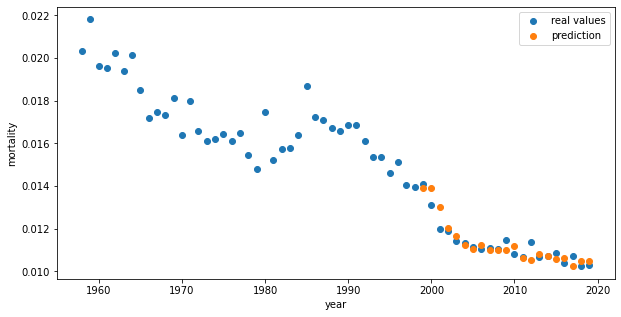

In [155]:
plt.figure(figsize=(10,5))
plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
plt.xlabel('year')
plt.ylabel('mortality')
plt.legend()
plt.savefig('figure.svg')

In [156]:
MAE = np.mean(np.abs(vals - real_vals[column].to_numpy()[-21:]))
MAE

0.0002970607748732406

# Jakiś nie działający przypadek:

In [ ]:
# jak cos nie styka
# split train test
def fit_arima_error(matrix):
    d = []
    for a in range(5):
        for b in range(2):
            for c in range(5):
                try:
                    mod = ARIMA(matrix, order=(a,b,c))
                    res = mod.fit()
                    d.append([res.llf, a, b, c])
                except ConvergenceWarning:
                    pass
    return d


def predict_error(matrix, column: str = 'Female_l', age = 65):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,0:round(np.shape(fm)[1]*2/3)]
    # fm_cross_val = fm.iloc[:,round(np.shape(fm)[1]*2/3):]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    N = np.shape(fm)[0]
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    bxkt = S[0] * np.dot(U[:, 0].reshape(N, 1), V[0, :].reshape(T, 1).T)

    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    d = fit_arima_error(k_t)
    for d_i in d:
        mod = ARIMA(k_t, order=(d_i[1],d_i[2],d_i[3]))
        # mod = ARIMA(k_t, order=(4,1,3))
        res = mod.fit()
        pred = res.forecast(steps=21)
        real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
        real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))


        plt.figure(figsize=(10,5))
        plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
        plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
        plt.xlabel('year')
        plt.ylabel('mortality')
        plt.legend()
        plt.show()


In [ ]:
age = 65
column = 'Male_l'
# vals = predict_error(mortality, column, age)


C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive pa

[[-112.15088027133137, 0, 0, 0], [-89.30898352319697, 0, 0, 1], [-71.39238715763278, 0, 0, 2], [-60.604046772633026, 0, 0, 3], [-56.431135547761144, 0, 0, 4], [-35.94647403889161, 0, 1, 0], [-35.503091016094935, 0, 1, 1], [-34.85866247175966, 0, 1, 2], [-34.73777978576339, 0, 1, 3], [-32.147531828543464, 0, 1, 4], [-45.03222264122037, 0, 2, 0], [-29.27066108074094, 0, 2, 1], [-27.983189671645825, 0, 2, 2], [-27.641608708875143, 0, 2, 3], [-27.34102633490344, 0, 2, 4], [-64.8862810402836, 0, 3, 0], [-46.19829806177408, 0, 3, 1], [-32.478526689954165, 0, 3, 2], [-31.539547682479782, 0, 3, 3], [-31.359228480232066, 0, 3, 4], [-84.13806644163853, 0, 4, 0], [-65.46483612421282, 0, 4, 1], [-48.88557809155118, 0, 4, 2], [-37.237792967405575, 0, 4, 3], [-36.610169869076415, 0, 4, 4], [-39.23560029449478, 1, 0, 0], [-38.77710587400632, 1, 0, 1], [-38.143281756106475, 1, 0, 2], [-38.040457770351885, 1, 0, 3], [-35.45656078054788, 1, 0, 4], [-35.31856092295754, 1, 1, 0], [-29.631580731508024, 1, 

C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\AppData\Local\Temp\ipykernel_14552\1635334433.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(a_x[age] + b_x[age]*pred)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   41
Model:                 ARIMA(2, 4, 2)   Log Likelihood                 -18.531
Date:                Fri, 10 Jun 2022   AIC                             47.062
Time:                        14:49:08   BIC                             55.117
Sample:                             0   HQIC                            49.902
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0008   1.98e-08   4.13e+04      0.000       0.001       0.001
ar.L2          0.9992   1.89e-05   5.28e+04      0.000       0.999       0.999
ma.L1         -1.9998      0.009   -222.342      0.0

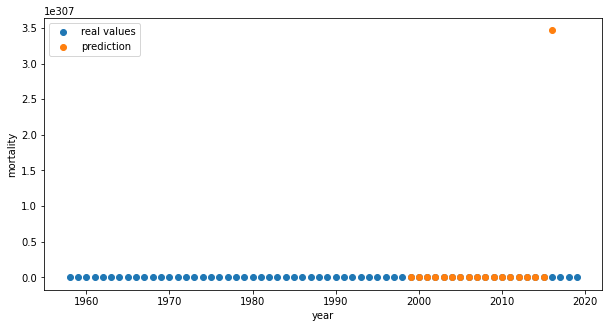

In [ ]:
age = 65
column = 'Female_l'
vals = predict(mortality, column, age)
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))
plt.figure(figsize=(10,5))
plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
plt.xlabel('year')
plt.ylabel('mortality')
plt.legend()
plt.savefig('figure.svg')